# GHG emissions of EU in a given year

This notebooks details the data preparation and plotting of pie chart showing the greenhouse gas emissions in the EU.

In [1]:
# Add parent dir to the path, so we can load the module.
import os
import sys
sys.path.append(os.path.abspath("../../../"))

import pandas as pd

from data_analysis.emissions_pie_chart import *
from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data

In [2]:
GEO = 'EU27_2020'
YEAR = 2021
TOTAL_EMISSION = 'TOTX4_MEMONIA'

definition = [
    {'id': 'electricty-heat',
     'label': 'Výroba elektřiny a tepla',
     'codes': ['CRF1A1A'],
     'color': '#ff4245',
     'breakdown': [
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'reminder': True},
     ]},
    {'id': 'industry',
     'label': 'Průmysl',
     'codes': ['CRF2', 'CRF1A2', 'CRF1A1B', 'CRF1A1C', 'CRF1A3E', 'CRF1B'],
     'color': '#7363bd',
     'breakdown': [
         {'id': 'CRF2C',
          'label': 'Ocel a jiné kovy',
          'color': '#6e3394',
          'codes': ['CRF1A2A', 'CRF1A2B', 'CRF2C']},
         {'id': 'CRF2A',
          'label': 'Cement a jiné minerály',
          'color': '#7a45a1',
          'codes': ['CRF1A2F', 'CRF2A']},
         {'id': 'fuels',
          'label': 'Těžba, zpracování a transport paliv',
          'color': '#7a45a1',
          'codes': ['CRF1A1B', 'CRF1A1C', 'CRF1A3E', 'CRF1B']},
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'reminder': True},
     ]},
    {'id': 'transport',
     'label': 'Doprava (včetně letecké)',
     'codes': ['CRF1A3A', 'CRF1A3B', 'CRF1A3C', 'CRF1A3D', 'CRF1D1A'],
     'color': '#a10014',
     'breakdown': [
         {'id': 'cars',
          'label': 'Osobní automobilová doprava',
          'color': '#73000c',
          'codes': ['CRF1A3B1']},
         {'id': 'trucks-buses',
          'label': 'Nákladní a autobusová doprava',
          'color': '#8f0a19',
          'codes': ['CRF1A3B2', 'CRF1A3B3']},
         {'id': 'airplanes',
          'label': 'Letecká doprava',
          'color': '#94545c',
          'codes': ['CRF1D1A', 'CRF1A3A']},
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'reminder': True}
     ]},
    {'id': 'buildings',
     'label': 'Budovy',
     'codes': ['CRF1A4A', 'CRF1A4B'],
     'color': '#00007f'},
    {'id': 'agriculture',
     'label': 'Zemědělství',
     'codes': ['CRF1A4C', 'CRF3'],
     'color': '#1ecfbd'},
    {'id': 'waste',
     'label': 'Odpadové hospodářství',
     'codes': ['CRF5'],
     'color': '#029485'},
    {'id': 'other',
     'label': 'Jiné',
     'color': '#f8c551',
     'reminder': True}
]


Second, emissions values (in megatons) are loaded for all CRF codes and EUA permit codes that appear in the definition.

In [3]:
df_eurostat = get_eurostat_crf_data(GEO, YEAR)

allowance_permit_codes = []
for wedge_def in definition:
    for sub_wedge in wedge_def.get('breakdown', []):
        allowance_permit_codes += sub_wedge['codes'] if 'allowances' in sub_wedge else []
df_eua = get_allowances_data(
    YEAR, allowance_permit_codes, "../../../data/EUA/verified_emissions_2021_en.xlsx")

df = pd.concat([df_eurostat, df_eua])
df


,value
CRF1,2662.74608
CRF1A,2601.56797
CRF1A1,840.44661
CRF1A1A,716.98300
CRF1A1B,92.82854
...,...
TOTX4_MEMONIA,3541.45464
TOTX4_MEMONIT,3670.54074
TOTXMEMO,3241.71565
TOTXMEMONIA,3311.46998


Third, list of inner and outer wedges is generated and printed into a CSV file (for processing in Illustrator).

In [10]:
total_value = get_emissions_value(TOTAL_EMISSION, df)
inner_wedges = get_emissions_wedges(definition, total_value, df)
inner_dict = {wedge.id: wedge.value for wedge in inner_wedges}

outer_wedges = []
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        parent_id = wedge_def['id']
        parent_value = inner_dict[parent_id]
        outer_wedges += get_emissions_wedges(
            wedge_def['breakdown'], parent_value, df, parent_id)

all_wedges = inner_wedges + outer_wedges
df_wedges = pd.DataFrame(all_wedges).set_index("id")
# Remove wedges with empty labels and remove the color column (not needed by Illustrator).
df_wedges = df_wedges[df_wedges["label"] != ""].drop("color", axis=1)
df_wedges.to_csv(f"{GEO}-wedges.csv")
df_wedges

,value,parent_id,label
id,,,
electricty-heat,716.98300,None,Výroba elektřiny a tepla
industry,942.11580,None,Průmysl
transport,847.16341,None,Doprava (včetně letecké)
buildings,454.63956,None,Budovy
agriculture,456.32480,None,Zemědělství
waste,109.28357,None,Odpadové hospodářství
other,14.94450,None,Jiné
industry_CRF2C,163.75324,industry,Ocel a jiné kovy
industry_CRF2A,188.45842,industry,Cement a jiné minerály


Lastly, a nested pie chart is generated for convenience.

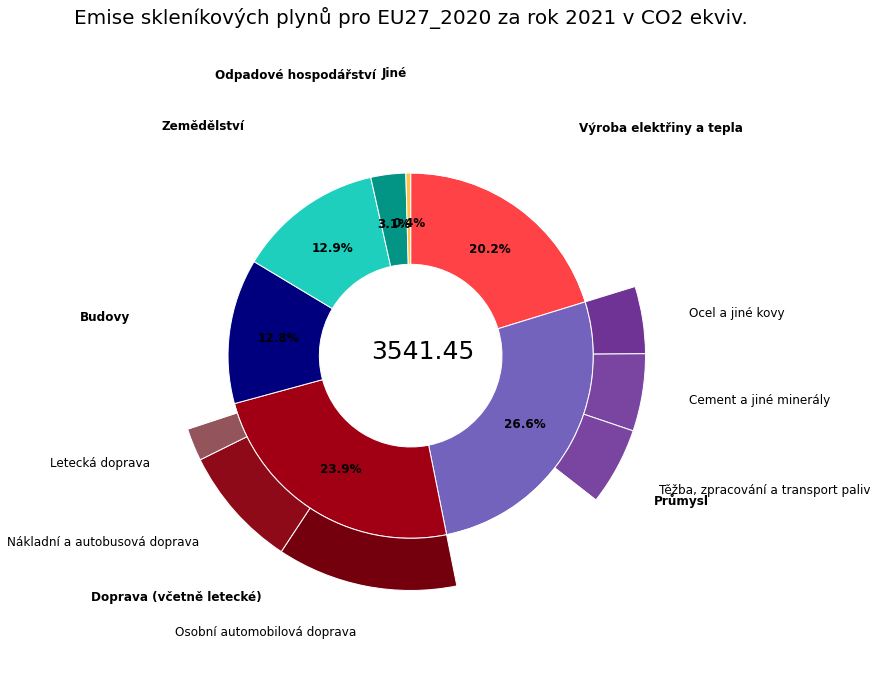

In [11]:
draw_emissions_pie_chart(GEO, YEAR, inner_wedges, outer_wedges, total_value)